# **Copyright Information**

####Copyright David Gündisch
#####El código original de este tutorial pertenece a David Gündisch. Este código fue modificado agregando comentarios, explicaciones e imágenes para ser una práctica interactiva educativa.


### **Laboratorio 8: Redes Generativas Adversariales**
En este laboratorio crearemos una Red Generativa Adversarial para generar nuevas imágenes de dígitos, similares a los dígitos del dataset MNIST.

**Nota: recuerde activar la conexión entre Google Colab y Google Drive**


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

# Install TensorFlow
try:
  # %tensorflow_version only works in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

In [0]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

Las Redes Generativas Adversariales son una forma de generar un modelo utilizando dos redes neurales que compiten una con otra.

El **generador** convierte ruido en una imitación de los datos intentando engañar al discriminador.

EL **discriminador** intenta identificar los datos reales de los datos falsos creados por el generador.

El generador recibe como entrada ruido aleatorio. Solamente el discriminador tiene acceso a los datos de entrenamiento para propósitos de clasificación.
El generador mejora el resultado de su salida solamente utilizando la retroalimentación obtenida del discriminador.

![texto alternativo](https://www.pngitem.com/pimgs/m/96-965914_a-short-introduction-to-generative-adversarial-networks-generative.png)

La clase GAN() contiene los métodos necesarios para construir nuestra red y entrenarla.

In [0]:
class GAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        
        #'''TODO: Especifique la dimensión del espacio latente e.g. 100'''
        self.latent_dim = 100
        #'''TODO: Especifique el optimizador que minimiza la función de perdida'''
        optimizer = Adam(0.0002,0.5)
        
        ### Discriminador de la GAN
        self.discriminator = self.build_discriminator()

        #'''TODO: Coloque la función de perdida y la métrica correcta para el discriminador, ponga atención al trabajo
        #que está realizando el discriminador. e.g. clasificación multiclase, clasificación binaria, regresión.'''
        self.discriminator.compile(loss='binary_crossentropy',
                                   optimizer=optimizer,
                                   metrics=['accuracy'])
        
        ### Generador de la GAN
        self.generator = self.build_generator()
        #'''TODO: z es la entrada hacia el generador (vector 1D de ruido). Indique la dimensión de entrada correcta para z.'''
        z = Input(shape=(self.latent_dim,))
        
       #'''TODO: el generador recibe ruido como entrada y devuelve una imagen'''
        img = self.generator(z)
        
        #'''TODO: No deseamos que la gradiente se propague hacia el discriminador, solamente deseamos propagar las gradientes
        #hacia el generador'''
        self.discriminator.trainable = False

        #'''TODO: El discriminador recibe la imagen creada por el generador y nos indica si la imagen es verdadera o falsa'''
        validity = self.discriminator(img)
        
        #'''TODO': Creamos un modelo con el generador y el discriminador unidos, especifique la entrada para el modelo completo
        #y la salida correspondiente. '''
        self.combined = Model(inputs= z, outputs= validity)
        
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):
        ### Este método construye la parte del generador de la GAN

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        
         #'''TODO: Agregue una capa totalmente conectada con una función de activación LeakyReLU y BatchNormalization.
         #  Agregue una nueva capa totalmente conectada adicional con función de activación LeakyReLU y BatchNormalization
         #  Recuerde que iniciamos nuestra entrada al generador con la dimensión del espacio latente e.g. 100, debemos ir
         #  aumentando las dimensiones de forma similar a la estructura utilizada en la sección 'decoder' en un autoencoder.
         #  Sabiendo esto debe indicar los valores correctos para la cantidad de salidas en cada capa densa.'''
        
        #'''TODO: capa 1'''
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        #'''TODO: capa 2'''
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        
        ### La penúltima capa del generador es un vector 1D con dimensión ancho_imagen x alto_imagen e.g.784
        
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        
        #'''TODO: Una imagen de un dígito de MNIST es un objeto 2D, nuestra capa anterior es 1D, debemos pasar de 1D (784,) 
        #a 2D (28,28) utilizando Reshape(new_size)'''
        model.add(Reshape(self.img_shape))
        
        model.summary()
        
        noise = Input(shape=(self.latent_dim,))
        img = model(noise)
        
        #'''TODO': La función build_generator() devuelve solamente la red neural que corresponde a la parte del generador.
        #    Recuerde lo que recibe el generador como entrada y que entrega en la salida.'''
        return Model(inputs=noise, outputs=img)

    def build_discriminator(self):
    
        model = Sequential()
        ### El discriminador es un clasificador, este clasificador no utiliza CNN, es un clasificador con una FCN, su entrada es un vector 1D
        model.add(Flatten(input_shape=self.img_shape))
        
        #'''TODO: agregue dos capas densas con función de activación LeakyRelu'''
        #'''TODO: capa 1'''
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        #'''TODO: capa 2'''
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))      
        
        #'''TODO: el discriminador es un clasificador. ¿Es un clasificador binario o debe clasificar mas de 2 clases?'''
        
        model.add(Dense(1, activation='sigmoid'))
        
        model.summary()
        
        img = Input(shape=self.img_shape)
        validity = model(img)
        
        #'''TODO': La función build_discriminator() devuelve solamente la red neural que corresponde a la parte del discriminador.
        #   Recuerde lo que recibe el discriminador como entrada y que entrega en la salida.'''
        return Model(inputs=img, outputs=validity)

    def train(self, epochs, batch_size=128, sample_interval=50):
        ### Método de entrenamiento de la GAN
        
        ### Se carga el dataset MNIST
        (X_train, _), (_, _) = mnist.load_data()
        
        ### Escalamos el valor de los pixels al rango (-1,1)
        X_train = X_train / 127.5 - 1.
        
        ### El dataset contiene 60k imágenes de 28x28 pixels, los caracteres son blanco y negro, por lo tanto usualmente 
        ### el shape del dataset no incluye canales. Expandimos nuestro dataset para indicar que solo tenemos 1 canal.
        ### dataset shape  = (60000, 28, 28) -> (60000, 28, 28, 1)
        X_train = np.expand_dims(X_train, axis=3)
        
        ### Etiquetas (labels) para enviar al discriminador para las imágenes verdaderas y falsas. 
        ### imagen verdadera = 1 , imagen falsa = 0
        ### valid.shape = (132, 1)   
        ### fake.shape(132,1)
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        ### Proceso iterativo de entrenamiento del modelo
        for epoch in range(epochs):
            
            ### Se carga un batch para entrenamiento
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]
            
            
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            #'''TODO: train_on_batch ejecuta una única actualización de gradiente con un batch de datos
                
            #   Entrenamos el generador en el modelo combinado, utilizando la retroalimentación
            #   que nos da el discriminador.         
            #   Realizamos foward_pass a través del modelo combinado generador + discriminador. 
            #   pero en backward_pass solo propagamos la gradiente hacia el generador, logramos esto 
            #   porque recuerde que anteriormente indicamos que los pesos del discriminador 
            #   serán no entrenables en el modelo combinado.
            #   Indicaremos que las etiquetas(labels) para las imágenes creadas por el generador 
            #   seran verdaderas e.g 1. (porque deseamos hacer pasarlas por reales)
             
            #  En un una iteración el discriminador está entrenado para distinguir 
            #   imágenes verdaderas y falsas.
            #   El generador a partir de ruido genera una imagen. En este momento
            #   no sabemos si esta imagen es lo suficiente buena para pasar por real, pero queremos hacerla 
            #   pasar por real, por lo tanto como etiqueta indicaremos que esta imagen es verdadera e.g 1.
            #   Deseamos que el generador se acerque lo mas posible a generar imágenes reales.
            #   Posteriormente esta imagen pasa al discriminador a través del modelo combinado y el 
            #   discriminador podrá decirnos si es verdadera o falsa.
            #   Utilizando esa información que nos da el discriminador, modificaremos los pesos del generador 
            #   para que la próxima iteración podamos acercarnos más a engañar al discriminador.'''
            

            g_loss = self.combined.train_on_batch(x=noise, y=valid)

            #'''TODO: Posteriormente de haber realizado una actualización de los pesos del generador, generaremos un batch de
            #   imágenes (falsas) a partir de ruido.''' 
            gen_imgs = self.generator.predict(noise)

            
            #'''TODO: Entrenamos al discriminador para que aprenda a clasificar 
            #   correctamente imágenes verdaderas. Para esto debemos enviarle ejemplos
            #   de imágenes reales. Las imágenes verdaderas son las imágenes
            #   que se obtienen del dataset MNIST. Debemos indicarle al discriminador 
            #   que estas imágenes son verdaderas, esto lo hacemos asignando a cada imagen una etiqueta
            #   verdadera e.g 1'''
            d_loss_real = self.discriminator.train_on_batch(x=imgs, y=valid)

            #'''TODO: Entrenamos al discriminador para que aprenda a identificar
            #   correctamente imágenes falsas. Para esto debemos enviarle ejemplos
            #   de imágenes falsas. Las imágenes falsas son las imágenes
            #   que se obtienen del generador. Debemos indicarle al discriminador 
            #   que estas imágenes son falsas, esto lo hacemos asignando a cada imagen una etiqueta
            #   falsa e.g 0'''
            d_loss_fake = self.discriminator.train_on_batch(x=gen_imgs, y=fake)

            ### valor de perdida del discriminador
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            
            if epoch % 50 == 0:
                print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100 * d_loss[1], g_loss))
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        ### Función que crea un archivo .png con ejemplos de imágenes nuevas generadas por
        ### el generador
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)
        gen_imgs = 0.5 * gen_imgs + 0.5
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
                axs[i, j].axis('off')
                cnt += 1
        fig.savefig("/content/drive/My Drive/%d.png" % epoch)
        plt.close()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_26 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_27 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_______________________________________________

FileNotFoundError: ignored

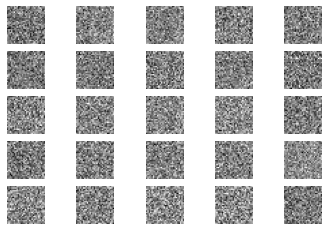

In [17]:
### Al finalizar el entrenamiento vea las imágenes resultantes 
### creadas por el generador a través de cada iteración en su directorio de Google Drive.
gan = GAN()
gan.train(epochs=100, batch_size=132, sample_interval=10000)